In [482]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [483]:
CHANNELS = 3
EPOCHS = 100
IMAGE_SIZE = 256
BATCH_SIZE = 25

In [484]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "RicePlantDataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1569 files belonging to 3 classes.


In [485]:
class_names = dataset.class_names
class_names

['BrownSpot', 'Healthy', 'LeafBlast']

In [486]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(25, 256, 256, 3)
[2 0 1 1 0 2 1 0 1 2 1 2 0 1 0 0 2 0 2 0 1 0 2 0 2]


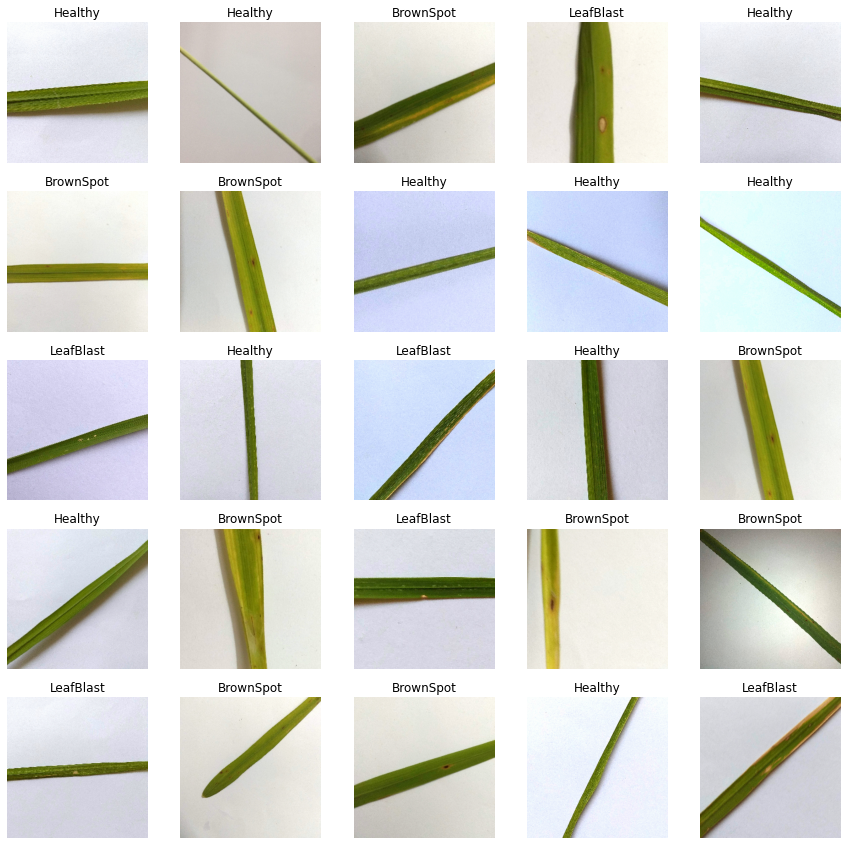

In [487]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [488]:
len(dataset)

63

In [489]:
train_size = 0.8
len(dataset) * train_size

50.400000000000006

In [490]:
test_ds = dataset.skip(28)
len(test_ds)

35

In [491]:
val_size = 0.1
len(dataset) * val_size

6.300000000000001

In [492]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [493]:
test_ds = test_ds.skip(6)
len(test_ds)

29

In [494]:
def get_partitioned_dataset_for_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [495]:
train_ds, val_ds, test_ds = get_partitioned_dataset_for_tf(dataset)

In [496]:
len(train_ds)

50

In [497]:
len(val_ds)

6

In [498]:
len(test_ds)

7

In [499]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [500]:
re_size_scale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [501]:
augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [502]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
class_num = 3

init_layer_size = 32
layer_size = 64
last_layer_size = 64

model = models.Sequential([
    re_size_scale,
    augmentation,
    layers.Conv2D(init_layer_size, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(layer_size,  kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(layer_size,  kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(layer_size, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(layer_size, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(last_layer_size, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(class_num, activation='softmax'),
])

model.build(input_shape=input_shape)

In [503]:
model.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_57 (Sequential)  (25, 256, 256, 3)         0         
                                                                 
 sequential_58 (Sequential)  (25, 256, 256, 3)         0         
                                                                 
 conv2d_116 (Conv2D)         (25, 254, 254, 32)        896       
                                                                 
 max_pooling2d_116 (MaxPooli  (25, 127, 127, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_117 (Conv2D)         (25, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_117 (MaxPooli  (25, 62, 62, 64)         0         
 ng2D)                                               

In [504]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [505]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 100,
)

Epoch 1/100
50/50 [==============================] - 97s 2s/step - loss: 1.1004 - accuracy: 0.3144 - val_loss: 1.0982 - val_accuracy: 0.3667
Epoch 2/100
50/50 [==============================] - 60s 1s/step - loss: 1.0764 - accuracy: 0.4080 - val_loss: 0.9772 - val_accuracy: 0.5267
Epoch 3/100
50/50 [==============================] - 59s 1s/step - loss: 0.9692 - accuracy: 0.5120 - val_loss: 0.9838 - val_accuracy: 0.4800
Epoch 4/100
50/50 [==============================] - 60s 1s/step - loss: 0.9448 - accuracy: 0.5320 - val_loss: 0.9291 - val_accuracy: 0.5667
Epoch 5/100
50/50 [==============================] - 66s 1s/step - loss: 0.9129 - accuracy: 0.5368 - val_loss: 0.9024 - val_accuracy: 0.5533
Epoch 6/100
50/50 [==============================] - 59s 1s/step - loss: 0.9449 - accuracy: 0.5184 - val_loss: 0.9288 - val_accuracy: 0.5400
Epoch 7/100
50/50 [==============================] - 60s 1s/step - loss: 0.9306 - accuracy: 0.5392 - val_loss: 0.9101 - val_accuracy: 0.5600
Epoch 8/100
5

Epoch 59/100
50/50 [==============================] - 57s 1s/step - loss: 0.6289 - accuracy: 0.7544 - val_loss: 0.6708 - val_accuracy: 0.6867
Epoch 60/100
50/50 [==============================] - 57s 1s/step - loss: 0.6348 - accuracy: 0.7416 - val_loss: 0.6515 - val_accuracy: 0.7333
Epoch 61/100
50/50 [==============================] - 57s 1s/step - loss: 0.6406 - accuracy: 0.7336 - val_loss: 0.5980 - val_accuracy: 0.7667
Epoch 62/100
50/50 [==============================] - 57s 1s/step - loss: 0.6399 - accuracy: 0.7328 - val_loss: 0.5939 - val_accuracy: 0.7733
Epoch 63/100
50/50 [==============================] - 57s 1s/step - loss: 0.6109 - accuracy: 0.7592 - val_loss: 0.6246 - val_accuracy: 0.7133
Epoch 64/100
50/50 [==============================] - 57s 1s/step - loss: 0.5970 - accuracy: 0.7552 - val_loss: 0.6088 - val_accuracy: 0.7333
Epoch 65/100
50/50 [==============================] - 57s 1s/step - loss: 0.6120 - accuracy: 0.7504 - val_loss: 0.6027 - val_accuracy: 0.7467
Epoch 

In [506]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 21s 231ms/step - loss: 0.4569 - accuracy: 0.8402


In [507]:
scores

[0.4569418728351593, 0.8402366638183594]

In [508]:
history

In [509]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 50}

In [510]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [511]:
type(history.history['loss'])

list

In [512]:
len(history.history['loss'])

100

In [513]:
history.history['loss'][:5]

[1.1003838777542114,
 1.076407551765442,
 0.9691537022590637,
 0.9448413848876953,
 0.9128526449203491]

In [514]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

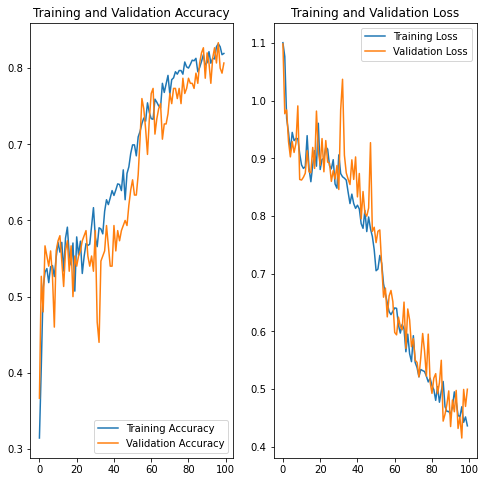

In [515]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: BrownSpot
predicted label: LeafBlast


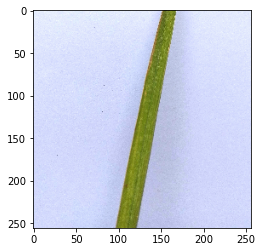

In [516]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [517]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predictedClass = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predictedClass, confidence

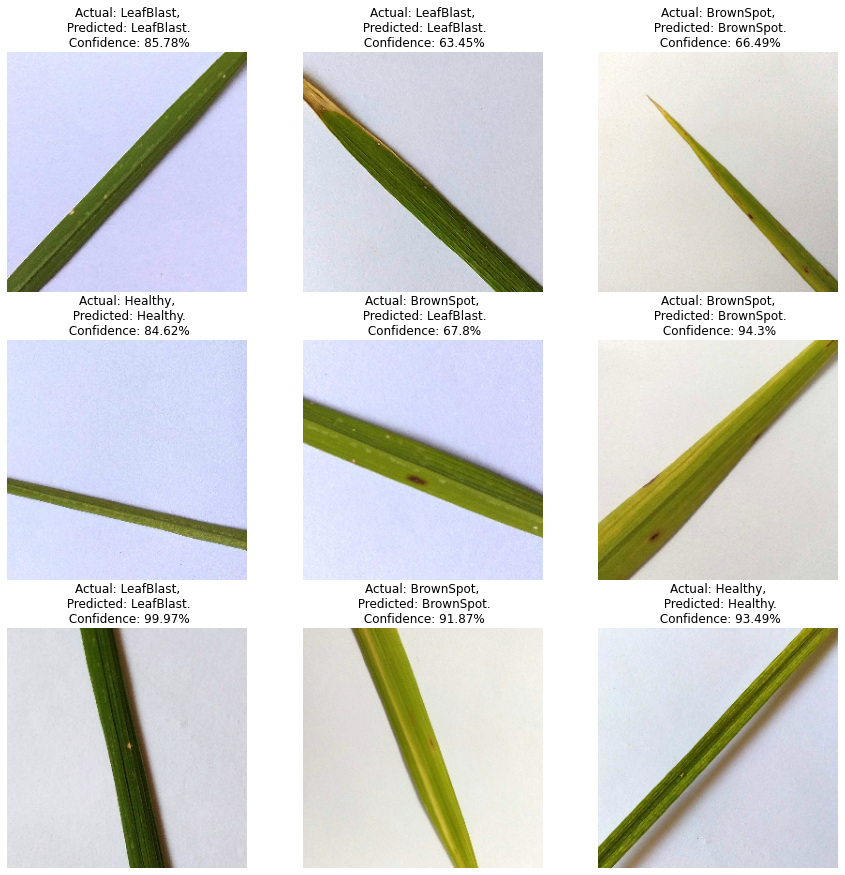

In [518]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [519]:
import os
modelVersion=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{modelVersion}")

INFO:tensorflow:Assets written to: ../models/3\assets
